### With no `scale_firing_rates` during training, but with `LoihiSpikingRectifiedLinear()` and  no regularization

Do not set `amplitude` and `max_rates` as you are not creating `Ensembles` from scratch, rather, converting a trained TF Model.

In [1]:
import numpy as np
import nengo
import nengo_dl
import nengo_loihi
import tensorflow as tf
import matplotlib.pyplot as plt

from nengo.utils.matplotlib import rasterplot

np.random.seed(0)
tf.random.set_seed(0)

# Get the dataset

In [2]:
(train_images, train_labels), (test_images, test_labels) = (
  tf.keras.datasets.mnist.load_data()
)
# Make it channels_first.
train_images, test_images = np.expand_dims(train_images, -1), np.expand_dims(test_images, -1)
train_images, test_images = np.moveaxis(train_images, -1, 1), np.moveaxis(test_images, -1, 1)

# Flatten images and add time dimension.
train_images = train_images.reshape((train_images.shape[0], 1, -1))
train_labels = train_labels.reshape((train_labels.shape[0], 1, -1))
test_images = test_images.reshape((test_images.shape[0], 1, -1))
test_labels = test_labels.reshape((test_labels.shape[0], 1, -1))

# Design the TF Model

In [3]:
inp = tf.keras.Input(shape=(1, 28, 28), name="input")

to_spikes = tf.keras.layers.Conv2D(
  filters=3, # 3 RGB Neurons per pixel.
  kernel_size=(1, 1), strides=(1, 1), activation=tf.nn.relu, use_bias=False, # Default is True.
  data_format="channels_first", name="to-spikes")(inp)

conv0 = tf.keras.layers.Conv2D(
  filters=8, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, use_bias=False,
  data_format="channels_first", name="conv0")(to_spikes)

conv1 = tf.keras.layers.Conv2D(
  filters=16, kernel_size=(3, 3), strides=(2, 2), activation=tf.nn.relu, use_bias=False,
  data_format="channels_first", name="conv1")(conv0)

flatten = tf.keras.layers.Flatten(name="flatten")(conv1)
dense0 = tf.keras.layers.Dense(64, activation=tf.nn.relu, name="dense0")(flatten)

#dense1 = tf.keras.layers.Dense(10, activation="softmax", name="dense1")(dense0) # Results in formation of TensorNode
                                                                                # which isn't supported on Loihi.
dense1 = tf.keras.layers.Dense(10, name="dense1")(dense0)

model = tf.keras.Model(inputs=inp, outputs=dense1)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1, 28, 28)]       0         
_________________________________________________________________
to-spikes (Conv2D)           (None, 3, 28, 28)         3         
_________________________________________________________________
conv0 (Conv2D)               (None, 8, 26, 26)         216       
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 12, 12)        1152      
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense0 (Dense)               (None, 64)                147520    
_________________________________________________________________
dense1 (Dense)               (None, 10)                650   

In [4]:
def _get_nengo_dl_model(**kwargs):
  converter = nengo_dl.Converter(model, **kwargs)
  lyr_probes = []
  with converter.net:
    probe_conv0 = nengo.Probe(converter.layers[conv0])
    probe_conv1 = nengo.Probe(converter.layers[conv1])
    probe_dense0 = nengo.Probe(converter.layers[dense0])
    lyr_probes.extend([probe_conv0, probe_conv1, probe_dense0])
  return converter, lyr_probes

# Train the model and save the Params

In [5]:
params_file, epochs = "./attempting_TN_MP_loihineurons_8_16", 4

converter, lyr_probes = _get_nengo_dl_model(
  #swap_activations={tf.nn.relu: nengo_loihi.neurons.SpikingRectifiedLinear()}, # With this neuron, spike amplitude
                                                                                # is more than 1.
  swap_activations={tf.nn.relu: nengo_loihi.neurons.LoihiSpikingRectifiedLinear()}, # Spike amplitude is just 1.
)
  
with nengo_dl.Simulator(converter.net, seed=0, minibatch_size=200) as sim:
    losses = {
      converter.outputs[dense1]: tf.losses.SparseCategoricalCrossentropy(from_logits=True)
    }
    
    metrics = {
      converter.outputs[dense1]: "accuracy"
    }
      
    sim.compile(
      loss=losses,
      optimizer=tf.optimizers.Adam(0.001),
      #metrics={converter.outputs[dense1]: tf.metrics.sparse_categorical_accuracy},
      metrics=metrics,
    )
    sim.fit(
      {converter.inputs[inp]: train_images},
      {converter.outputs[dense1]: train_labels},
      epochs=epochs,
    )
    
    # save the parameters to file.
    sim.save_params(params_file)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Epoch 1/4
300/300 [==============================] - 2s 8ms/step - loss: 0.2084 - probe_loss: 0.2084 - probe_accuracy: 0.9379
Epoch 2/4
300/300 [==============================] - 2s 8ms/step - loss: 0.0595 - probe_loss: 0.0595 - probe_accuracy: 0.9816
Epoch 3/4
300/300 [==============================] - 2s 8ms/step - loss: 0.0365 - probe_loss: 0.0365 - probe_accuracy: 0.9889
Epoch 4/4
300/300 [==============================] - 2s 8ms/step - loss: 0.0233 - probe_loss: 0.0233 - probe_accuracy: 0.9923


# Print the `gain`, `bias`, `intercepts`, and `max_rates` of the `Dense0` layer

In [6]:
print(sim.data[converter.layers[dense0].ensemble].gain)
print(sim.data[converter.layers[dense0].ensemble].bias)
print(sim.data[converter.layers[dense0].ensemble].intercepts)
print(sim.data[converter.layers[dense0].ensemble].max_rates)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


/home/rgaurav/miniconda3/envs/latest-nengo-tf/lib/python3.7/site-packages/nengo_dl/simulator.py:2266: UserWarning: Checking parameters after simulator is closed; cannot fetch live values, so the initial values will be returned.
  "Checking parameters after simulator is closed; "


# Test the NengoDL Model

In [7]:
n_steps=30
scale_firing_rates=100
synapse=0.005
n_test=100
sfr=100

nengo_converter, layer_probes = _get_nengo_dl_model(
    scale_firing_rates=sfr, 
    #swap_activations={tf.nn.relu: nengo_loihi.neurons.SpikingRectifiedLinear()}, # With this neuron, spike 
                                                                                  # amplitude is more than 1.
    swap_activations={tf.nn.relu: nengo_loihi.neurons.LoihiSpikingRectifiedLinear()}, # Spike Amplitude is just 1.
    synapse=synapse
)
  
tiled_test_images = np.tile(test_images[:n_test], (1, n_steps, 1))
# Speed up simulation.
with nengo_converter.net:
  nengo_dl.configure_settings(stateful=False)
    
# Build network, load in trained weights, do inference.
with nengo_dl.Simulator(
    nengo_converter.net, minibatch_size=20, progress_bar=False) as sim:
  sim.load_params(params_file)
  data = sim.predict({nengo_converter.inputs[inp]: tiled_test_images})
    
test_predictions = np.argmax(data[nengo_converter.outputs[dense1]][:, -1], axis=-1)
print("Nengo DL Test Acc: %s" % (100 * np.mean(test_predictions == test_labels[:n_test, 0, 0])))

Nengo DL Test Acc: 97.0


# Plotting the spikes in Conv0 layer

<AxesSubplot:>

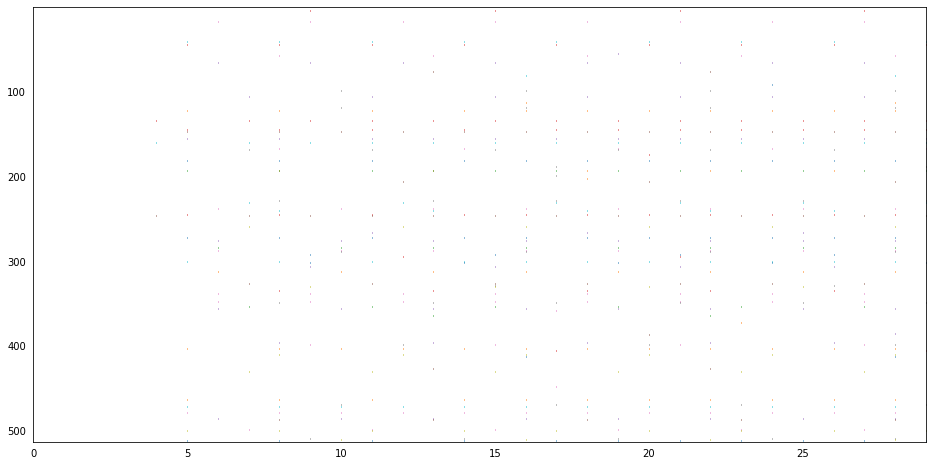

In [8]:
plt.figure(1, figsize=(16,8))
rasterplot(np.arange(0, n_steps), data[layer_probes[0]][0, :, np.random.choice(5408, 512, replace=False)].T)

# Print the spikes in `Conv0` layer (only if their amplitude is more than 1)

In [9]:
conv0_spikes_matrix = data[layer_probes[0]] * sfr * 0.001
test_image_index = 0

for neuron in range(data[layer_probes[0]].shape[2]):
  if np.any(conv0_spikes_matrix[test_image_index, :, neuron]):
    spikes=np.round(conv0_spikes_matrix[test_image_index, :, neuron])
    if set(np.unique(spikes)) - set([0, 1]):
      print(spikes)